In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

## Load and prepare data

In [2]:
# forest loss data
df_forest = pd.read_csv('Data/district_forest_cover.csv')

# SPEI growing period data
df_spei = pd.read_csv('Data/district_province_spei_growingperiod.csv')

# rename season_year column in SPEI df
df_spei = df_spei.rename(columns={'season_year': 'year'})

# population data
df_pop = pd.read_csv('Data/district_pop_growth.csv')

# clean columns
df_pop = df_pop.drop(columns=['Unnamed: 0'])

for df in [df_forest, df_pop, df_spei]:
    df['district'] = df['district'].str.strip().str.title()

# calculate population density
# load district shapefile
districts_gdf = gpd.read_file('Data/district.shp')

# set CRS
districts_gdf = districts_gdf.set_crs(epsg=4326)

# reproject to a metric CRS
districts_gdf = districts_gdf.to_crs(epsg=32735)

# compute area (square kilometers)
districts_gdf['district_area_km2'] = districts_gdf['geometry'].area / 1e6

# standardize district names
districts_gdf['district'] = districts_gdf['NAME_2'].str.strip().str.title()
df_pop['district'] = df_pop['district'].str.strip().str.title()

# drop geometry
area_df = districts_gdf[['district', 'district_area_km2']]

# merge with population
df_pop = df_pop.merge(area_df, on='district', how='left')

# calculate population density
df_pop['pop_density'] = df_pop['population'] / df_pop['district_area_km2']

merged = (df_forest
          .merge(df_pop,  on=['district', 'year'], how='outer')
          .merge(df_spei, on=['district', 'year'], how='outer'))

# calculate percent forest cover in 2000
merged['percent_forest_2000'] = (merged['forest_2000_m2'] / merged['district_area_km2']) * 100

# compute SPEI lags
merged = merged.sort_values(['district', 'year'])
for lag in range(1, 6):
    merged[f'mean_spei_lag{lag}'] = (
        merged.groupby('district')['mean_growing_spei'].shift(lag)
    )

model_vars = ['percent_loss_annual', 'mean_spei_lag5',
              'pop_density', 'percent_forest_2000']

cleaned = merged[
    (merged['year'].between(2001, 2020)) & 
    merged[model_vars].notna().all(axis=1)
].copy()

# center population density
cleaned['pop_density_c'] = cleaned['pop_density'] - cleaned['pop_density'].mean()

# scale population density
# for every 100 person per km^2 increase in pop density, annual forest loss increases by 0.062%
cleaned['pop_density_c_scaled'] = cleaned['pop_density_c'] / 100

# within-district centering to isolate changes over time
cleaned['pop_density_wi'] = (
    cleaned['pop_density_c_scaled'] -
    cleaned.groupby('district')['pop_density_c_scaled'].transform('mean')
)

# create interaction term
cleaned['spei5_x_popdens'] = cleaned['mean_spei_lag5'] * cleaned['pop_density_wi']
    
cleaned.head()

ERROR 1: PROJ: proj_create_from_database: Open of /mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/share/proj failed


,district,year,forest_cover_ha,loss_m2,percent_loss_annual,forest_2000_m2,population,pop_growth,district_area_km2,pop_density,...,percent_forest_2000,mean_spei_lag1,mean_spei_lag2,mean_spei_lag3,mean_spei_lag4,mean_spei_lag5,pop_density_c,pop_density_c_scaled,pop_density_wi,spei5_x_popdens
5,Chadiza,2005,56703.324923,7.047053e+05,0.124125,5.723238e+08,67476.906250,0.020426,1518.283564,44.442888,...,3.769545e+07,-0.079997,0.227219,0.281255,0.364988,0.841021,-72.500730,-0.725007,-0.062118,-0.052243
6,Chadiza,2006,56388.063193,3.152617e+06,0.555985,5.723238e+08,68212.812500,0.010906,1518.283564,44.927584,...,3.769545e+07,-0.699067,-0.079997,0.227219,0.281255,0.364988,-72.016034,-0.720160,-0.057271,-0.020903
7,Chadiza,2007,56253.107717,1.349555e+06,0.239333,5.723238e+08,68965.882812,0.011040,1518.283564,45.423585,...,3.769545e+07,0.170735,-0.699067,-0.079997,0.227219,0.281255,-71.520033,-0.715200,-0.052311,-0.014713
8,Chadiza,2008,55860.402357,3.927054e+06,0.698104,5.723238e+08,71330.296875,0.034284,1518.283564,46.980879,...,3.769545e+07,0.760298,0.170735,-0.699067,-0.079997,0.227219,-69.962739,-0.699627,-0.036738,-0.008348
9,Chadiza,2009,55677.381107,1.830213e+06,0.327640,5.723238e+08,71971.171875,0.008985,1518.283564,47.402984,...,3.769545e+07,0.189313,0.760298,0.170735,-0.699067,-0.079997,-69.540634,-0.695406,-0.032517,0.002601


## Regression model

In [12]:
# log-transformed outcome
cleaned['log_loss'] = np.log1p(cleaned['percent_loss_annual'])

model_log = smf.ols(
    'log_loss ~ mean_spei_lag5 + pop_density_wi + spei5_x_popdens + percent_forest_2000 + C(district)',
    data=cleaned
).fit()

print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:               log_loss   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     11.40
Date:                Sun, 22 Jun 2025   Prob (F-statistic):           6.79e-88
Time:                        21:31:58   Log-Likelihood:                -264.95
No. Observations:                1104   AIC:                             673.9
Df Residuals:                    1032   BIC:                             1034.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## Plot

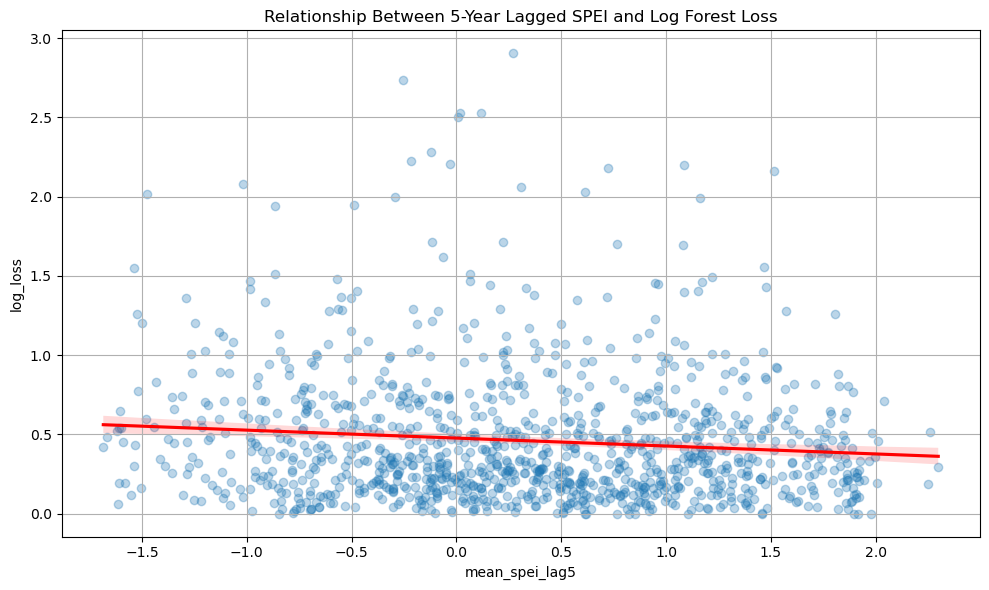

In [5]:
# overall scatterplot with regression line
plt.figure(figsize=(10,6))
sns.regplot(
    data=cleaned,
    x='mean_spei_lag5',
    y='log_loss',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

plt.title('Relationship Between 5-Year Lagged SPEI and Log Forest Loss')
plt.xlabel('mean_spei_lag5')
plt.ylabel('log_loss')
plt.grid(True)
plt.tight_layout()
plt.show()

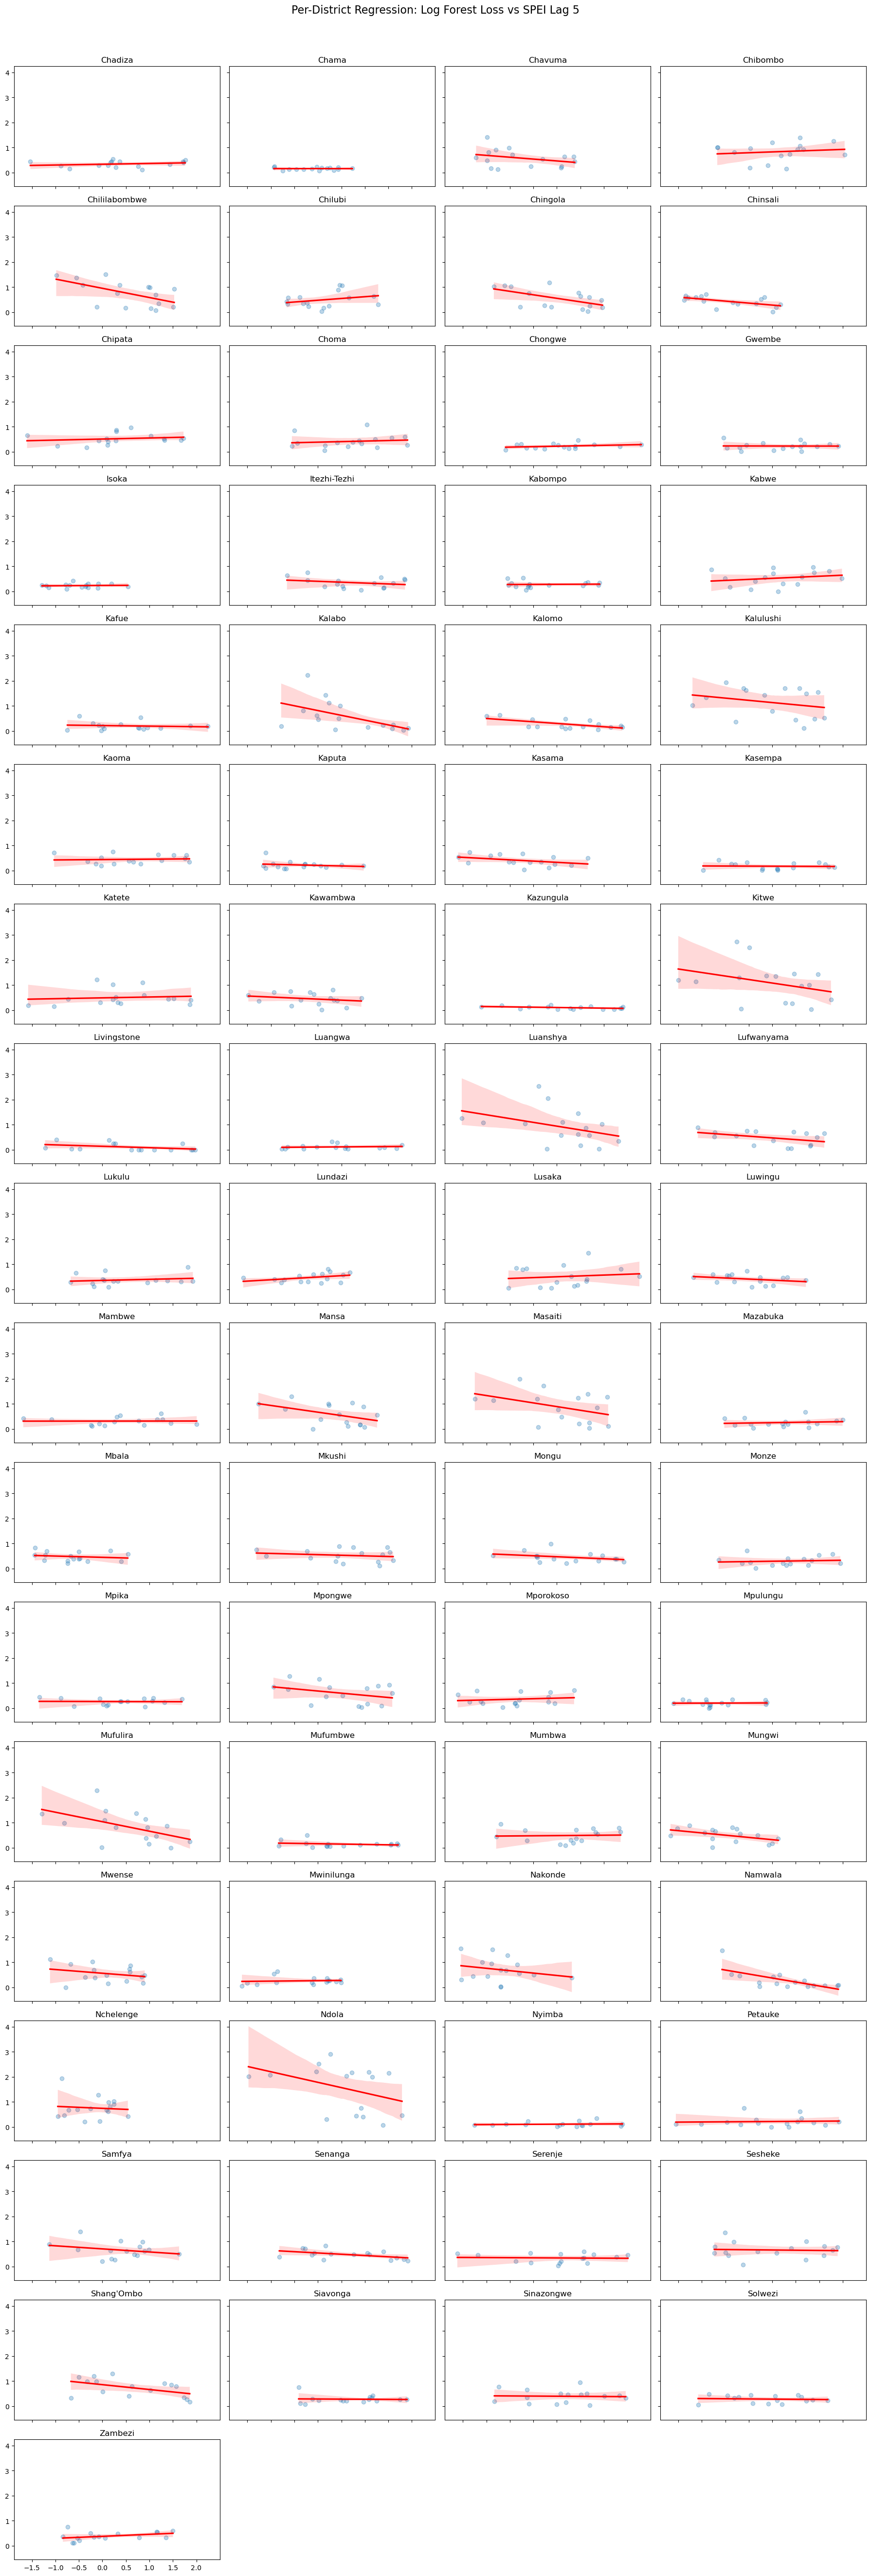

In [9]:
# per district regression lines

# get unique districts
districts = cleaned['district'].dropna().unique()

# set subplots
ncols = 4
nrows = (len(districts) + ncols - 1) // ncols

# set up subplot grid
fig, axes = plt.subplots(nrows, ncols, figsize=(18, nrows * 3), sharex=True, sharey=True)

# flatten axes array
axes = axes.flatten()

for i, district in enumerate(districts):
    ax = axes[i]
    subset = cleaned[cleaned['district'] == district]
    if subset['mean_spei_lag5'].nunique() < 2:
        continue

    sns.regplot(
        data=subset,
        x='mean_spei_lag5', 
        y='log_loss',
        ax=ax,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'}
    )
    ax.set_title(district)
    ax.set_ylabel('')
    ax.set_xlabel('')

# hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Per-District Regression: Log Forest Loss vs SPEI Lag 5', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()